In [1]:
%matplotlib inline

In [2]:
import sys
import numpy as np
import pandas as pd
import re as re
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
train = pd.read_csv('../data/train.csv', header = 0, dtype={'Age': np.float64})
test = pd.read_csv('../data/test.csv', header = 0, dtype={'Age': np.float64})
full_data = [train, test]

In [4]:
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0,0.5,u'people')

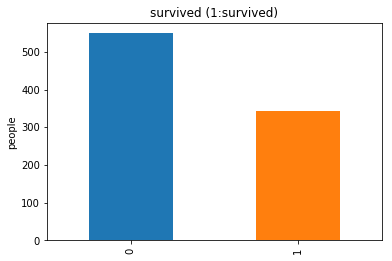

In [6]:
train.Survived.value_counts().plot(kind='bar')
plt.title(u"survived (1:survived)") # 标题
plt.ylabel(u"people")

Text(0,0.5,u'cabin_level')

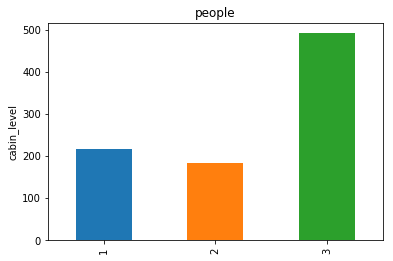

In [7]:
train.Pclass.value_counts(sort = False).plot(kind='bar')
plt.title(u"people")
plt.ylabel(u"cabin_level")

Text(0.5,1,u'age-survived (1:survived)')

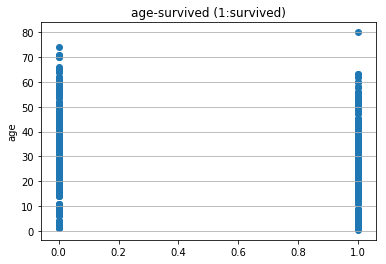

In [8]:
plt.scatter(train.Survived, train.Age)
plt.ylabel(u"age")
plt.grid(b = True, which = 'major', axis = 'y')
plt.title(u"age-survived (1:survived)")

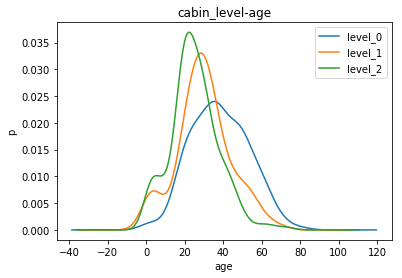

In [9]:
train.Age[train.Pclass == 1].plot(kind='kde') # Kernel Density Estimation
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
plt.xlabel(u"age")
plt.ylabel(u"p")
plt.title(u"cabin_level-age")
plt.legend((u'level_0', u'level_1', u'level_2'), loc = 'best')

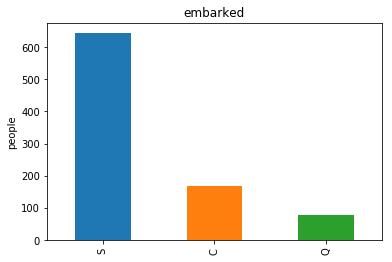

In [10]:
train.Embarked.value_counts().plot(kind='bar')
plt.title(u"embarked")
plt.ylabel(u"people")
plt.show()

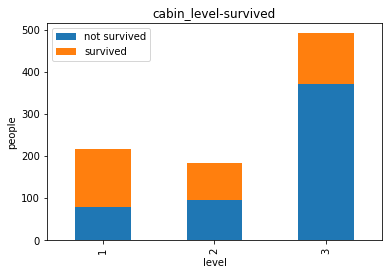

In [11]:
Survived_0 = train.Pclass[train.Survived == 0].value_counts()
Survived_1 = train.Pclass[train.Survived == 1].value_counts()
df = pd.DataFrame({u'survived':Survived_1, u'not survived':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"cabin_level-survived")
plt.xlabel(u"level")
plt.ylabel(u"people")
plt.show()

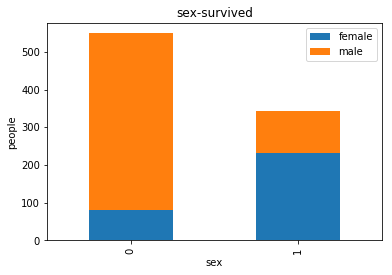

In [12]:
Survived_m = train.Survived[train.Sex == 'male'].value_counts()
Survived_f = train.Survived[train.Sex == 'female'].value_counts()
df = pd.DataFrame({u'male':Survived_m, u'female':Survived_f})
df.plot(kind='bar', stacked=True)
plt.title(u"sex-survived")
plt.xlabel(u"sex")
plt.ylabel(u"people")
plt.show()

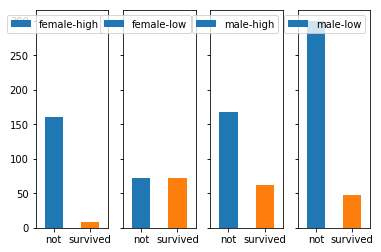

In [13]:
fig = plt.figure()

ax1 = fig.add_subplot(141)
train.Survived[train.Sex == 'female'][train.Pclass != 3].value_counts().plot(kind='bar', label="female, high class")
ax1.set_xticklabels([u"not", u"survived"], rotation = 0)
ax1.legend([u"female-high"], loc='best')

ax2 = fig.add_subplot(142, sharey=ax1)
train.Survived[train.Sex == 'female'][train.Pclass == 3].value_counts().plot(kind='bar', label="female, low class")
ax2.set_xticklabels([u"not", u"survived"], rotation = 0)
ax2.legend([u"female-low"], loc='best')

ax3 = fig.add_subplot(143, sharey=ax1)
train.Survived[train.Sex == 'male'][train.Pclass != 3].value_counts().plot(kind='bar', label="male, high class")
ax3.set_xticklabels([u"not", u"survived"], rotation = 0)
ax3.legend([u"male-high"], loc='best')

ax4 = fig.add_subplot(144, sharey=ax1)
train.Survived[train.Sex == 'male'][train.Pclass == 3].value_counts().plot(kind='bar', label="male, low class")
ax4.set_xticklabels([u"not", u"survived"], rotation = 0)
ax4.legend([u"male-low"], loc='best')

plt.show()

In [14]:
for dataset in full_data:
    # Gives the length of the name
    dataset['Name_length'] = dataset['Name'].apply(len)
    
    # Feature that tells whether a passenger had a cabin on the Titanic
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# SibSp and Parch

In [15]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index = False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [16]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Age', 'Survived']].groupby(['IsAlone'], as_index = False).mean())

   IsAlone        Age  Survived
0        0  26.413452  0.505650
1        1  32.220297  0.303538


# Embarked

In [17]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


# Fare

In [18]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index = False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


# Age

In [19]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index = False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.526786
1   (16.0, 32.0]  0.357798
2   (32.0, 48.0]  0.365019
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


d:\program files (x86)\python\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Name

In [20]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
print (pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [21]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
                                                'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                                'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Miss')

print (train[['Title', 'Survived']].groupby(['Title'], as_index = False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.704301
2      Mr  0.156673
3     Mrs  0.792000
4    Rare  0.347826


In [22]:
for dataset in full_data:
    # Mopping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mopping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mopping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mopping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mopping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

id_series = pd.Series(test["PassengerId"])
test = test.drop(drop_elements, axis = 1)

print (train.head(10))
print (test.head(10))

train_pd, test_pd = train, test

train = train.drop(['Parch', 'FamilySize'], axis = 1)
test = test.drop(['Parch', 'FamilySize'], axis = 1)

train = train.values
test = test.values

   Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Name_length  Has_Cabin  \
0         0       3    1    1      0     0         0           23          0   
1         1       1    0    2      0     3         1           51          1   
2         1       3    0    1      0     1         0           22          0   
3         1       1    0    2      0     3         0           44          1   
4         0       3    1    2      0     1         0           24          0   
5         0       3    1    1      0     1         2           16          0   
6         0       1    1    3      0     3         0           23          1   
7         0       3    1    0      1     2         0           30          0   
8         1       3    0    1      2     1         0           49          0   
9         1       2    0    0      0     2         1           35          0   

   FamilySize  IsAlone  Title  
0           2        0      1  
1           2        0      3  
2           1        1 

In [23]:
print(train)

[[0 3 1 ... 0 0 1]
 [1 1 0 ... 1 0 3]
 [1 3 0 ... 0 1 2]
 ...
 [0 3 0 ... 0 0 2]
 [1 1 1 ... 1 1 1]
 [0 3 1 ... 0 1 1]]


In [24]:
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.cross_validation import KFold

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls


import warnings
warnings.filterwarnings('ignore')



d:\program files (x86)\python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


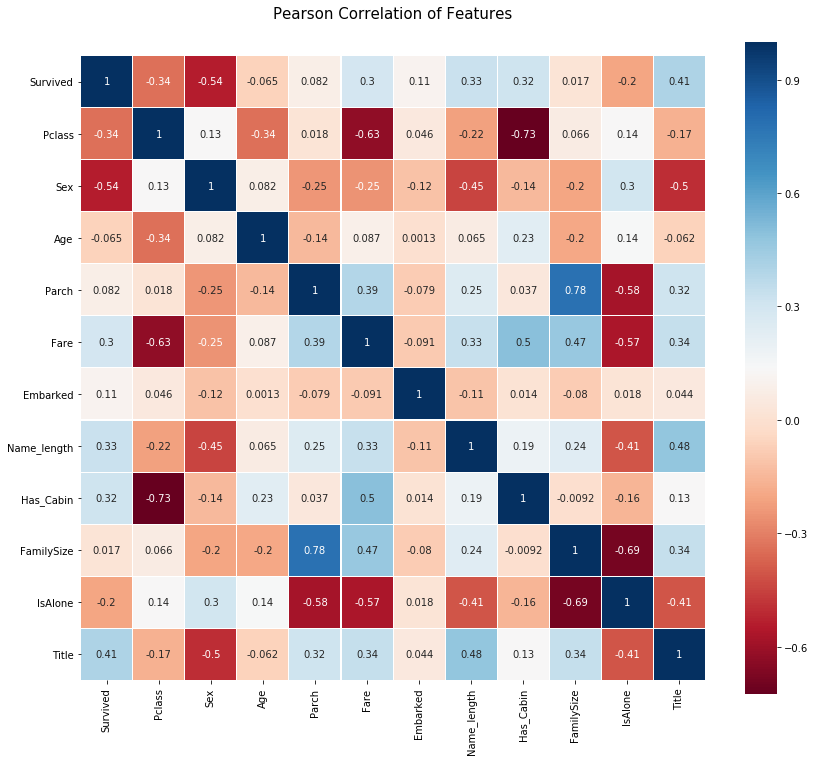

In [25]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_pd.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

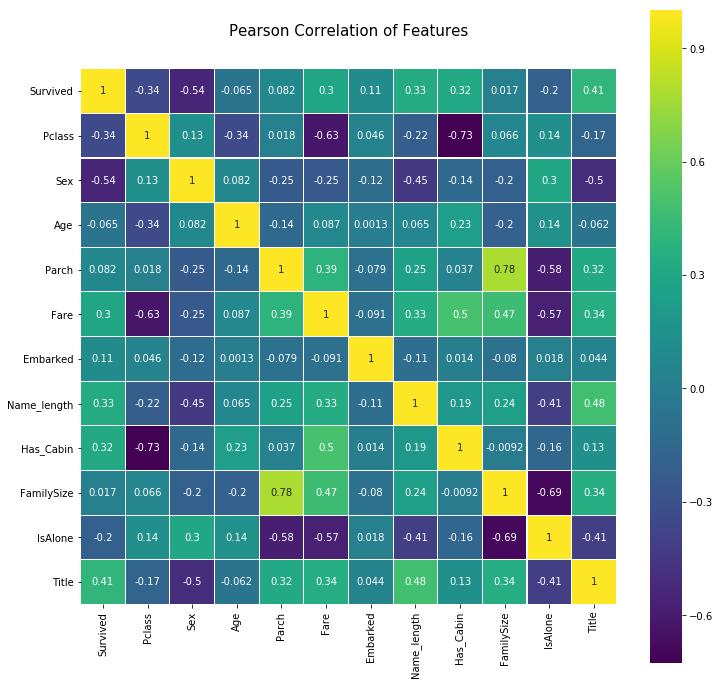

In [26]:
colormap = plt.cm.viridis
plt.figure(figsize=(12, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_pd.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

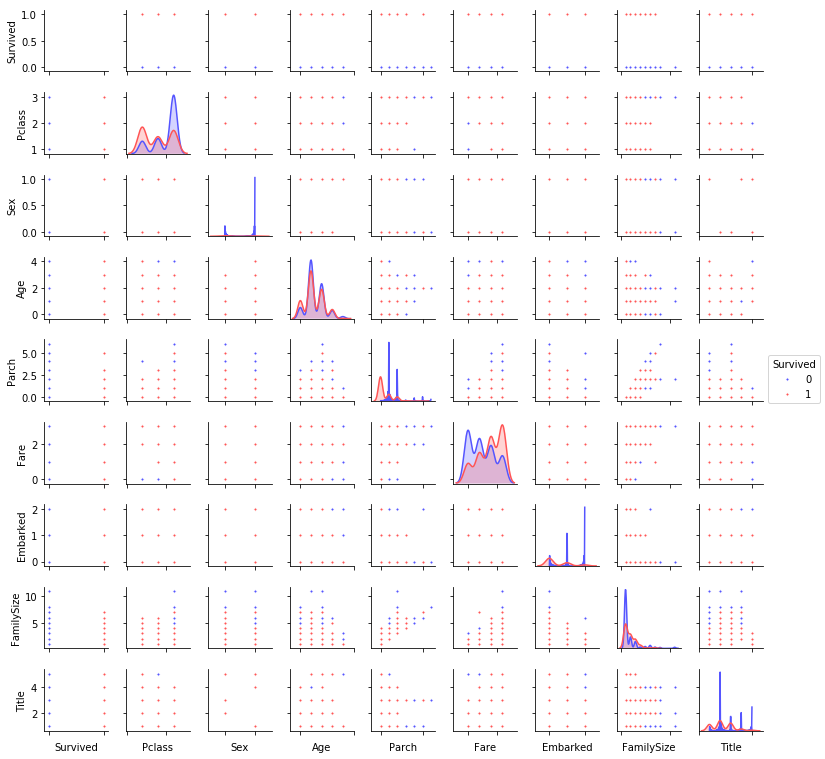

In [27]:
g = sns.pairplot(train_pd[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',\
                          u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size=1.2, diag_kind = \
                'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Classifier Comparison

In [28]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

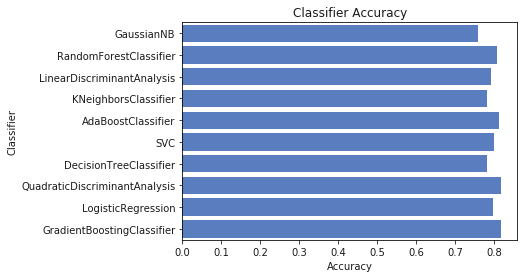

In [29]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # print (y_train.shape, y_test.shape)
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
        
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    # print (log_entry)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [30]:
candidate_classifier = SVC()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

In [31]:
print(result)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1
 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 1 0 1 0 0 1]


In [32]:
result_df = pd.DataFrame({"PassengerId": id_series, "Survived": result})
result_df.to_csv('../data/result.csv', index=False)

In [33]:
train_pd.shape[0]

891

In [34]:
# Some useful parameters which will come in handy later on
ntrain = train_pd.shape[0]
ntest = test_pd.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds = NFOLDS, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print (self.clf.fit(x, y).feature_importances_)


In [35]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [36]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [37]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [38]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train_pd['Survived'].ravel()
train_noy = train_pd.drop(['Survived'], axis=1)
x_train = train_noy.values # Creates an array of the train data
x_test = test_pd.values # Creats an array of the test data
print (x_train.shape, x_test.shape)

((891L, 11L), (418L, 11L))


In [39]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [40]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12638753 0.2009811  0.03197136 0.02063311 0.07240631 0.02380082
 0.10761001 0.06487074 0.065657   0.01387488 0.27180715]
[0.12084639 0.37708981 0.03197655 0.01698412 0.0557962  0.02842979
 0.04602318 0.08405785 0.04342873 0.0213986  0.17396877]
[0.034 0.01  0.018 0.066 0.038 0.01  0.688 0.014 0.05  0.006 0.066]
[0.07323762 0.04638878 0.10383967 0.02912721 0.09332792 0.0506004
 0.38720991 0.0229637  0.07116724 0.02311823 0.0990193 ]


In [41]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [42]:
cols = train_noy.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [43]:
print (feature_dataframe)

    AdaBoost feature importances  Extra Trees  feature importances  \
0                       0.028000                          0.121657   
1                       0.008000                          0.370983   
2                       0.012000                          0.031296   
3                       0.058667                          0.015916   
4                       0.032000                          0.055258   
5                       0.008000                          0.028157   
6                       0.046667                          0.045898   
7                       0.000000                          0.020304   
8                       0.057333                          0.172896   
9                       0.738667                          0.048535   
10                      0.010667                          0.089101   

    Gradient Boost feature importances  Random Forest feature importances  \
0                             0.067961                           0.104741   
1    

In [44]:
py.init_notebook_mode(connected=True)

In [45]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [46]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.121657,0.067961,0.104741,Pclass,0.080590
1,0.008,0.370983,0.038893,0.218370,Sex,0.159062
2,0.012,0.031296,0.072378,0.044327,Age,0.040000


In [47]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

In [48]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [49]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [50]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [51]:
print (x_train)

[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [52]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [53]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': id_series,
                            'Survived': predictions })
StackingSubmission.to_csv("../data/StackingSubmission.csv", index=False)